In [1]:
# Quoridor game implementation
import functools
import numpy as np
import itertools
import random
import heapq

class QuoridorState:
    '''
    Quoridor state container class - generalized by size N
    Attributes:
        positions: 2x2 tuple representing the positions of the players
        left_wall: 1x2 tuple representing the number of walls left for each player
        walls: NxNx2 numpy array representing the walls
    '''
    def __init__(self, N: int = 9, n_walls: int = 10, copy: 'QuoridorState' = None):
        self.N = N
        if copy is not None:
            self.N = copy.N
            self.positions = copy.positions.copy()
            self.left_wall = copy.left_wall.copy()
            self.walls = copy.walls.copy()
            self.board = copy.board.copy()
            self.move_cnt = copy.move_cnt
        else:
            self.positions = np.array([[0, self.N // 2], [self.N - 1, self.N // 2]])
            self.left_wall = np.array([n_walls, n_walls])
            self.walls = np.zeros((2, self.N - 1, self.N - 1), dtype=np.int8)
            self.board = self.init_board()
            self.move_cnt = 0


    def init_board(self):
        '''
        Returns a 2N-1x2N-1 numpy array representing the board
        '''
        board = np.zeros((self.N * 2 - 1, self.N * 2 - 1), dtype=np.int8)
        board[1::2, 1::2] = 1
        board[self.positions[0, 0] * 2, self.positions[0, 1] * 2] = 2
        board[self.positions[1, 0] * 2, self.positions[1, 1] * 2] = 3
        return board

    def copy(self):
        return QuoridorState(copy=self)

    def encode(self, player):
        '''
        Returns 4xNxN numpy array representing the state
        channel 1: position of current player
        channel 2: position of opponent player
        channel 3: horizontal walls
        channel 4: vertical walls
        If player is 1, the board is flipped vertically
        '''
        encoded = np.zeros((4, self.N, self.N), dtype=np.float32)

        encoded[player, self.positions[0, 0], self.positions[0, 1]] = 1
        encoded[1 - player, self.positions[1, 0], self.positions[1, 1]] = 1
        encoded[(0, 1), :, :] = encoded[(0, 1), :, :] if player == 0 else np.flip(encoded[(0, 1), :, :], axis=1)

        walls_1 = self.walls[0, :, :] if player == 0 else np.flipud(self.walls[1, :, :])
        walls_2 = self.walls[1, :, :] if player == 0 else np.flipud(self.walls[0, :, :])
        encoded[2, :, :] = np.pad(walls_1 == 1, ((0, 1), (0, 1)), 'constant', constant_values=0)
        encoded[3, :, :] = np.pad(walls_2 == 1, ((0, 1), (0, 1)), 'constant', constant_values=0)
        return encoded

class Quoridor:
    '''
    Quoridor rule management class
    '''
    def __init__(self, N, n_walls):
        self.N = N
        self.n_walls = n_walls

    def get_initial_state(self):
        '''
        Returns the initial state of the game
        '''
        state = QuoridorState(self.N, self.n_walls)
        return state

    def _search_on_board(self, state: QuoridorState, player):
        '''
        Returns the distance of shortest path to the goal of given player using a* algorithm.
        1 is wall, 0 is path
        if player 0: end at (2N - 2, *)
        if player 1: end at (0, *)
        heuristic: column-distance to the goal
        '''
        board = state.board
        now_pos = state.positions[player] * 2
        queue = []
        heapq.heappush(queue, (2 * self.N - 2, 0, 0, now_pos))

        visited = np.zeros((2 * self.N - 1, 2 * self.N - 1), dtype=np.int8)
        temp = 0
        while queue:
            _, _, g, pos = heapq.heappop(queue)
            if pos[0] < 0 or pos[0] > 2 * self.N - 2 or pos[1] < 0 or pos[1] > 2 * self.N - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if pos[0] == (2 * self.N - 2) * (1 - player):
                return g

            visited[*pos] = 1
            for i in range(4):
                e = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])[i]
                new_pos = pos + e
                h = (2 * self.N - 2 - new_pos[0]) * (1 - player) + (2 * new_pos[0]) * player
                heapq.heappush(queue, (h + g + 1, temp := temp+1, g + 1, pos + e))

        return -1


    def is_valid_wall(self, state: QuoridorState):
        '''
        Returns True if the state is valid, False otherwise
        Conditions for a valid state:
            - Walls are not blocking the path to the goal
        '''
        return self._search_on_board(state, 0) != -1 and self._search_on_board(state, 1) != -1

    def _search_valid_moves(self, state: QuoridorState, player):
        '''
        Returns a list of valid moves from the given position using dfs
        1 is wall, 0 is path
        2 is player 0, 3 is player 1
        stack: [(pos, n_step)]
        n_step stops at 2
        reset step when board[pos] == 2 or 3
        '''
        board = state.board
        now_pos = state.positions[player] * 2
        movable = []
        stack = []
        stack.append((now_pos, 0))
        visited = np.zeros((2 * self.N - 1, 2 * self.N - 1), dtype=np.int8)
        while len(stack) > 0:
            pos, step = stack.pop()
            if pos[0] < 0 or pos[0] > 2 * self.N - 2 or pos[1] < 0 or pos[1] > 2 * self.N - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if board[*pos] == 2 or board[*pos] == 3:
                step = 0
            visited[*pos] = 1
            if step == 2:
                movable.append(pos // 2)
                continue
            for e in np.array([[-1, 0], [1, 0], [0, -1], [0, 1]]):
                stack.append((pos + e, step + 1))

        return movable


    def is_valid_move(self, state: QuoridorState, next_pos, player):
        '''
        Returns True if the next state is a valid move, False otherwise
        Conditions for a valid move:
            - The player is moving to a valid position
        '''
        cvt_pos = np.array(next_pos)
        if any([np.array_equal(cvt_pos, val_mov) for val_mov in self._search_valid_moves(state, player)]):
            return True
        else:
            return False


    def get_next_state(self, state: QuoridorState, action: tuple, player: int):
        '''
        Returns the next state of the game given the current state and action
        '''
        action_type, row, col = action

        next_state = QuoridorState(copy=state)
        next_state.move_cnt += 1

        if action_type == 0:
            if self.is_valid_move(next_state, (row, col), player):
                next_state.board[*next_state.positions[player] * 2] = 0
                next_state.board[*np.array((row, col)) * 2] = player + 2
                next_state.positions[player] = (row, col)
                return next_state
            else:
                # print('Invalid move')
                return None
        else:
            if next_state.left_wall[player] == 0:
                # print('No wall left')
                return None

            hv = action_type - 1
            if next_state.walls[hv, row, col] != 0:
                # print('Invalid wall')
                return None

            next_state.walls[hv, row, col] = 1
            next_state.walls[1 - hv, row, col] = -1
            if hv == 0 and col > 0:
                next_state.walls[0, row, col - 1] = -1
            if hv == 1 and row > 0:
                next_state.walls[1, row - 1, col] = -1
            if hv == 0 and col < self.N - 2:
                next_state.walls[0, row, col + 1] = -1
            if hv == 1 and row < self.N - 2:
                next_state.walls[1, row + 1, col] = -1
            next_state.board[
                row * 2 - hv + 1 : row * 2 + hv + 2,
                col * 2 - (1 - hv) + 1 : col * 2 + (1 - hv) + 2
            ] = 1
            next_state.left_wall[player] -= 1
            if not self.is_valid_wall(next_state):
                # print('Invalid wall')
                return None

            return next_state

    def get_valid_actions(self, state: QuoridorState, player: int):
        moves = self._search_valid_moves(state, player)
        walls = [
            (hv, r, c)
            for hv in range(2) for r in range(self.N - 1) for c in range(self.N - 1)
            if self.get_next_state(state, (hv + 1, r, c), player) is not None
        ]
        actions = np.zeros((3, self.N, self.N))
        for move in moves:
            actions[0, *move] = 1
        for hv, r, c in walls:
            actions[1 + hv, r, c] = 1
        return actions

    def check_win(self, state: QuoridorState, player):
        '''
        Returns True if the player wins, False otherwise
        '''
        if state.positions[player][0] == (self.N - 1) * (1 - player):
            return True
        else:
            return False

    def get_draw_value(self, state: QuoridorState, player: int):
        '''
        Returns the reward of the given state. Possibly value can be heuristic, not only win-lose.
        '''
        p_value = self._search_on_board(state, player)
        o_value = self._search_on_board(state, 1 - player)

        if p_value + o_value == 0:
            print(p_value, o_value)
            print(state.board)
            print(state.positions)
        return p_value / (p_value + o_value)

    def get_value_and_terminated(self, state: QuoridorState, player: int):
        '''
        Returns whether the game is terminated and the reward of the given state.
        If the game progresses more than 50 moves, the game is forced to terminate.
        '''
        if state.move_cnt > 50:
            return True, True, self.get_draw_value(state, player)
        if self.check_win(state, player):
            return True, False, 1
        else:
            return False, False, 0


def parse_cmd(cmd: str) -> tuple:
    s = cmd.split(' ')
    if s[0] == 'move':
        return 0, (int(s[1]), int(s[2]))
    elif s[0] == 'wall':
        return 1 + s[1], (int(s[2]), int(s[3]))
    else:
        raise ValueError('Invalid action type')


In [2]:
test_quoridor = Quoridor(3, 1)
test_state = test_quoridor.get_initial_state()
test_state = test_quoridor.get_next_state(test_state, (1, 1, 1), 0)
print(test_state.board, test_state.left_wall)

test_state = test_quoridor.get_next_state(test_state, (1, 0, 0), 1)
test_state = test_quoridor.get_next_state(test_state, (0, 0, 0), 0)
print(test_state.board, test_state.left_wall)
print(test_quoridor.get_draw_value(test_state, 0))
print(test_quoridor.get_draw_value(test_state, 1))


[[0 0 2 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 1 1 1 1]
 [0 0 3 0 0]] [0 1]
[[2 0 0 0 0]
 [1 1 1 1 0]
 [0 0 0 0 0]
 [0 1 1 1 1]
 [0 0 3 0 0]] [0 0]
0.5454545454545454
0.45454545454545453


In [3]:
import math
import random

import tqdm


class Node:
    def __init__(
            self,
            game: Quoridor,
            args,
            state: QuoridorState,
            player,
            parent: 'Node' = None,
            action_taken = None):

        self.game = game
        self.args = args
        self.state = state
        self.player = player
        self.parent = parent
        self.action_taken = action_taken

        self.children: list['Node'] = []
        self.expandable_actions = self.game.get_valid_actions(self.state, self.player)

        self.visit_count = 0
        self.total_value = 0

    def is_fully_expanded(self):
        return np.sum(self.expandable_actions) == 0 and len(self.children) > 0

    def select(self) -> 'Node':
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child

        return best_child

    def get_ucb(self, child: 'Node'):
        q_value = child.total_value / child.visit_count
        return q_value + self.args['C'] * math.sqrt(math.log(self.visit_count) / child.visit_count)


    def expand(self):
        action = random.choice(
            list(zip(*np.where(self.expandable_actions == 1)))
        )
        self.expandable_actions[action] = 0

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action, self.player)

        child = Node(self.game, self.args, child_state, 1 - self.player, self, action)
        self.children.append(child)
        return child

    def simulate(self):
        rollout_state = self.state.copy()
        rollout_player = self.player
        while True:
            # print(self.turn_count, rollout_count)

            valid_actions = self.game.get_valid_actions(rollout_state, rollout_player)
            action = random.choice(
                list(zip(*np.where(valid_actions == 1)))
            )
            rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)

            is_terminal, is_draw, value = self.game.get_value_and_terminated(rollout_state, rollout_player)
            if is_terminal:
                return is_draw, value

            rollout_player = 1 - rollout_player

    def backpropagate(self, value, is_draw):
        self.visit_count += 1
        if is_draw:
            self.total_value += value * self.args['draw_discount']
        else:
            self.total_value += value

        if self.parent is not None:
            self.parent.backpropagate(1 - value, is_draw)


class MCTS:
    def __init__(self, game: Quoridor, args) -> None:
        self.game = game
        self.args = args

    def search(self, state, player):
        root = Node(self.game, self.args, state, player)

        for _ in tqdm.trange(self.args['n_searches']):
            node = root

            while node.is_fully_expanded():
                # print(node.expandable_actions, node.children)
                node = node.select()

            is_terminal, is_draw, value = self.game.get_value_and_terminated(node.state, 1 - node.player)

            if not is_terminal:
                node = node.expand()
                is_draw, value = node.simulate()
                value = 1 - value

            node.backpropagate(value, is_draw)

        action_probs = np.zeros((3, self.game.N, self.game.N), dtype=np.float32)
        for idx, child in enumerate(root.children):
            q_value = child.total_value / child.visit_count
            visit_rate = child.visit_count / root.visit_count
            action_probs[*child.action_taken] = q_value + math.sqrt(visit_rate) * 0.1
        action_probs /= np.sum(action_probs, axis=(0, 1, 2))
        return action_probs



In [4]:
import matplotlib.pyplot as plt


def plot_policy(policy, valid_actions, state: QuoridorState, player):
    if policy is None:
        policy = np.zeros((3, state.N, state.N))
    plt.figure(num=0)
    plt.axis()
    rect = plt.Rectangle((-0.5, -0.5), state.N, state.N, fc='w', ec='k')
    plt.gca().add_patch(rect)

    policy /= np.max(policy, axis=(0, 1, 2)) + 1e-8

    for i in range(state.N):
        for j in range(state.N):
            rate = float(policy[0, i, j])
            color = np.array([1-rate, 0, rate, 1]) if valid_actions[0, i, j] == 1 else 'w'
            rect = plt.Rectangle((i-0.3, j-0.3), 0.6, 0.6, fc=color, ec='k')
            plt.gca().add_patch(rect)

    for i in range(state.N - 1):
        for j in range(state.N - 1):
            rate = float(policy[1, i, j])
            color = 'k' if state.walls[0, i, j] == 1 else ('w' if valid_actions[1, i, j] == 0 else np.array([1-rate, 0, rate, 1]))
            rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.5), 0.2, 1, fc=color, ec='k')
            plt.gca().add_patch(rect)

            rate = float(policy[2, i, j])
            color = 'k' if state.walls[1, i, j] == 1 else ('w' if valid_actions[2, i, j] == 0 else np.array([1-rate, 0, rate, 1]))
            rect = plt.Rectangle((i+0.5-0.5, j+0.5-0.1), 1, 0.2, fc=color, ec='k')
            plt.gca().add_patch(rect)

            rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.1), 0.2, 0.2, fc='k', ec='k')
            plt.gca().add_patch(rect)



    circle = plt.Circle((state.positions[0, 0], state.positions[0, 1]), 0.1, fc='g' if player == 0 else 'w', ec='k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((state.positions[1, 0], state.positions[1, 1]), 0.1, fc='g' if player == 1 else 'k', ec='k')
    plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

In [ ]:
quoridor = Quoridor(3, 2)
player = 0

args = {
    'C': 2,
    'N': 1000,
}

mcts = MCTS(quoridor, args)

state = quoridor.get_initial_state()

while True:
    print(state.board)
    print(state.left_wall)

    if player == 0:
        valid_actions = quoridor.get_valid_actions(state, player)
        print(valid_actions,valid_actions)
        cmd = input('Player 1: ')
        action = parse_cmd(cmd)
        print('action',action)
        if action[1] not in valid_actions:
            print('Invalid action')
            continue
    else:
        mcts_actions, mcts_probs = mcts.search(state, player)
        print(mcts_actions, '\n', mcts_probs)
        action = mcts_actions[np.argmax(mcts_probs)]
        print(action)

    state = quoridor.get_next_state(state, action, player)
    is_terminal = quoridor.check_win(state, player)

    if is_terminal:
        print(state.board)
        print('Player {} wins'.format(player))
        break

    player = 1 - player


[[0 0 2 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 3 0 0]]
[2 2]
[[[1. 0. 1.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[1. 1. 0.]
  [1. 1. 0.]
  [0. 0. 0.]]

 [[1. 1. 0.]
  [1. 1. 0.]
  [0. 0. 0.]]]


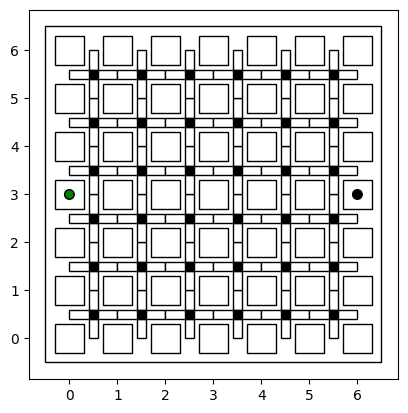

 11%|█         | 53/500 [00:10<01:31,  4.86it/s]


KeyboardInterrupt: 

In [ ]:
quoridor = Quoridor(5, 3)

args = {
    'draw_discount': 0.0,
    'C': 2,
    'n_searches': 500,
}

mcts = MCTS(quoridor, args)

state = quoridor.get_initial_state()

player = 0
zeros = np.zeros((3, quoridor.N, quoridor.N))
plot_policy(zeros, zeros, state, player)
while True:
    mcts_probs = mcts.search(state, player)
    action = np.unravel_index(np.argmax(mcts_probs), mcts_probs.shape)

    a_t, r, c = action
    new_state = quoridor.get_next_state(state, (a_t, r, c), player)

    plot_policy(mcts_probs, quoridor.get_valid_actions(state, player), new_state, player)

    state = new_state

    is_terminal, _, value = quoridor.get_value_and_terminated(state, player)

    if is_terminal:
        print('game over')
        break

    player = 1 - player
